In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

import calc_gas_collision_spectrum as calc_gas

In [30]:
import importlib
importlib.reload(utils)
importlib.reload(calc_gas)

<module 'calc_gas_collision_spectrum' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../calc_gas_collision_spectrum.py'>

In [3]:
sphere = 'sphere_20260105'
amp2kev = 6935.448138438464

def read_recon(file):
    f = h5py.File(file, 'r')

    amps = f['data_processed']['amplitude'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    # chi2 = f['data_processed']['chisquare'][:]

    f.close()

    return amps, good_detection, noise_level_amp

def get_summed_histogram(dataset, type, file_prefix, nfiles, amp2kev, noise_threshold_kev=200):
    bins = np.arange(0, 10000, 25)  # keV
    bc = 0.5 * (bins[:-1] + bins[1:])

    hh_all = np.zeros_like(bc, dtype=np.int64)
    pressures = []
    for i in range(nfiles):
        file = rf'/Users/yuhan/work/nanospheres/data/gas_data_processed/{sphere}/{type}/{dataset}/{file_prefix}{i}_processed.hdf5'
        amps, good_detection, noise_level_amp = read_recon(file)

        good_window = np.logical_and(good_detection, noise_level_amp*amp2kev < noise_threshold_kev)
        _hh, _ = np.histogram(np.abs(amps[good_window].flatten()) * amp2kev, bins)
        hh_all += _hh

    return bc, hh_all

In [4]:
def get_average_pressure(dataset, type, file_prefix, nfiles):
    sphere = 'sphere_20260105'
    # data_dir = rf'/Volumes/LaCie/gas_collisions/{type}/{sphere}/{dataset}'
    data_dir = rf'/Users/yuhan/work/nanospheres/data/gas_collisions/{type}/{sphere}/{dataset}'

    pressures = np.empty(nfiles)
    for i in range(nfiles):
        file = os.path.join(data_dir, f'{file_prefix}{i}.hdf5')
        f = h5py.File(file, "r")

        pressures[i] = f['data'].attrs['pressure_mbar']

    return np.mean(pressures)

In [5]:
bc, hh_all_bg_0 = get_summed_histogram('20260107_p8e_4e-8mbar', 'background_data', '20260107_df_', 150, amp2kev, 100)
bc, hh_all_bg_1 = get_summed_histogram('20260107_p8e_3e-8mbar_valveclosed', 'background_data', '20260107_df_', 150, amp2kev, 100)

bc, hh_all_xe_0 = get_summed_histogram('20260107_p8e_5e-8mbar', 'xenon_data', '20260107_df_', 150, amp2kev, 100)
bc, hh_all_xe_1 = get_summed_histogram('20260107_p8e_6e-8mbar', 'xenon_data', '20260107_df_', 150, amp2kev, 100)
bc, hh_all_xe_2 = get_summed_histogram('20260107_p8e_8e-8mbar', 'xenon_data', '20260107_df_', 150, amp2kev, 100)
bc, hh_all_xe_3 = get_summed_histogram('20260107_p8e_1e-7mbar', 'xenon_data', '20260107_df_', 150, amp2kev, 100)
bc, hh_all_xe_4 = get_summed_histogram('20260107_p8e_2e-7mbar', 'xenon_data', '20260107_df_', 150, amp2kev, 100)

In [6]:
p_bg_0 = get_average_pressure('20260107_p8e_4e-8mbar', 'background_data', '20260107_df_', 150)
p_bg_1 = get_average_pressure('20260107_p8e_3e-8mbar_valveclosed', 'background_data', '20260107_df_', 150)

p_xe_0 = get_average_pressure('20260107_p8e_5e-8mbar', 'xenon_data', '20260107_df_', 150)
p_xe_1 = get_average_pressure('20260107_p8e_6e-8mbar', 'xenon_data', '20260107_df_', 150)
p_xe_2 = get_average_pressure('20260107_p8e_8e-8mbar', 'xenon_data', '20260107_df_', 150)
p_xe_3 = get_average_pressure('20260107_p8e_1e-7mbar', 'xenon_data', '20260107_df_', 150)
p_xe_4 = get_average_pressure('20260107_p8e_2e-7mbar', 'xenon_data', '20260107_df_', 150)

p_xe = [p_xe_0, p_xe_1, p_xe_2, p_xe_3, p_xe_4]
p_xe_effective = (np.asarray([p_xe_0, p_xe_1, p_xe_2, p_xe_3, p_xe_4]) - p_bg_0) * 0.4

In [7]:
hhs_xe = [hh_all_xe_0, hh_all_xe_1, hh_all_xe_2, hh_all_xe_3, hh_all_xe_4]

In [35]:
def get_xe_theory(sphere_radius, pressure_mbar, sig_p_kev):
    qq_kev = np.linspace(10, 10000, 200)

    dr_dq_diffuse_xe = calc_gas.dgamma_dp_diffuse(qq_kev, 131.3, pressure_mbar, 293, 1000, 50e-9)
    dr_dq_xe = calc_gas.dgamma_dp(qq_kev, 131.3, pressure_mbar, 1, 293, 50e-9)

    qqz, drdqz = calc_gas.get_drdqz(qq_kev, dr_dq_xe)
    qqz, drdqz_diffuse = calc_gas.get_drdqz(qq_kev, dr_dq_diffuse_xe)

    # print(drdqz)
    qqzn, drdqzn_xe = calc_gas.smear_drdqz_gauss(qqz, drdqz, sig_p_kev)
    qqzn, drdqzn_diffuse_xe = calc_gas.smear_drdqz_gauss(qqz, drdqz_diffuse, sig_p_kev)

    return qqzn, drdqzn_xe, drdqzn_diffuse_xe

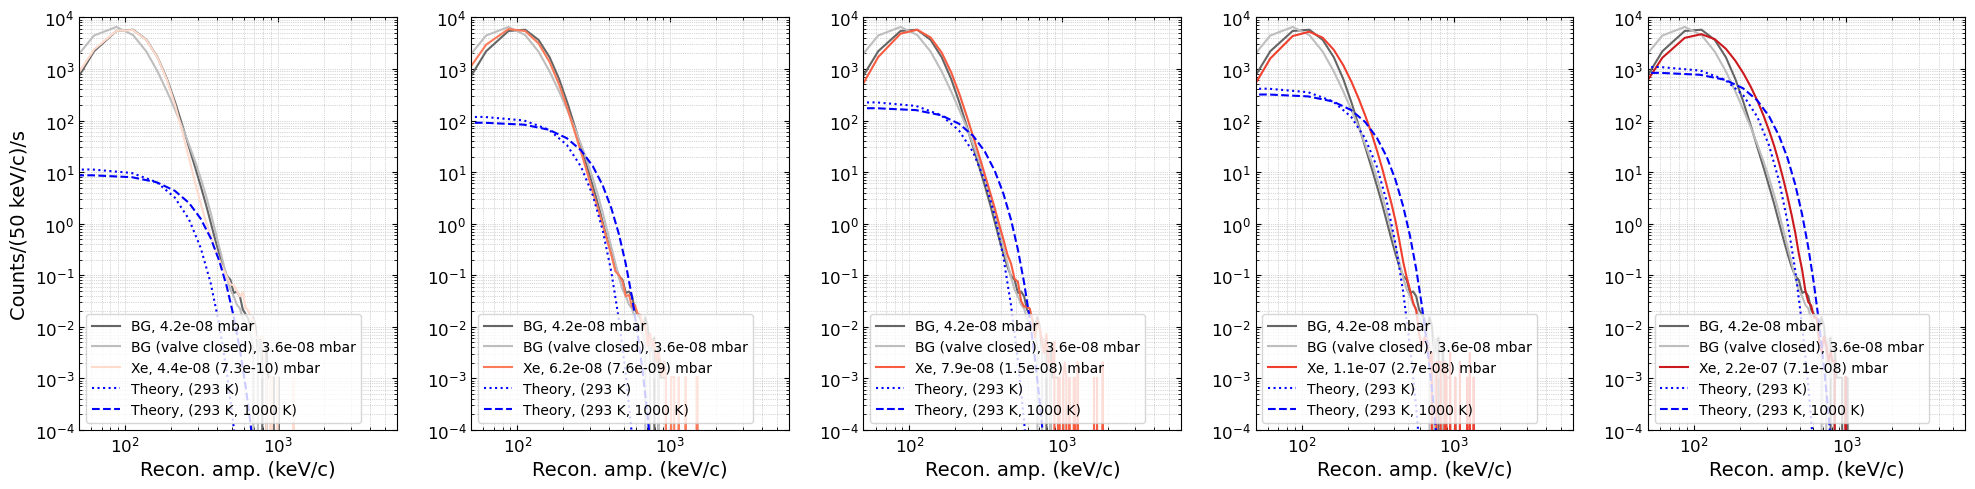

In [43]:
cmap = plt.colormaps.get_cmap('Greys')
colors_bg = cmap((np.log(np.asarray([p_bg_0, p_bg_1])) - np.log(3e-8)) / (np.log(5e-8) - np.log(3e-8)))

cmap = plt.colormaps.get_cmap('Reds')
colors_xe = cmap((np.log(p_xe_effective) - np.log(2.5e-10)) / (np.log(5e-7) - np.log(2.5e-10)))

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.plot(bc, hh_all_bg_0/(50e-6 * np.sum(hh_all_bg_0)), color=colors_bg[0], label=f'BG, {p_bg_0:.1e} mbar')
    ax.plot(bc, hh_all_bg_1/(50e-6 * np.sum(hh_all_bg_1)), color=colors_bg[1], label=f'BG (valve closed), {p_bg_1:.1e} mbar')

    ax.plot(bc, hhs_xe[i]/(50e-6 * np.sum(hhs_xe[i])), color=colors_xe[i], label=f'Xe, {p_xe[i]:.1e} ({p_xe_effective[i]:.1e}) mbar')

    sigma_p_kev = 51.60153892357829
    qq_kev, drdqzn_xe, drdqzn_hot_xe = get_xe_theory(50e-9, p_xe_effective[i], sigma_p_kev)
    ax.plot(qq_kev, drdqzn_xe*50, 'b:', label=f'Theory, (293 K)')
    ax.plot(qq_kev, drdqzn_hot_xe*50, 'b--', label='Theory, (293 K, 1000 K)')

    ax.set_xlim(50, 6000)
    ax.set_ylim(1e-4, 1e4)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both', ls=':', linewidth=0.5)

    ax.legend(fontsize=10, loc=3)

    ax.set_xlabel('Recon. amp. (keV/c)')
axes[0].set_ylabel('Counts/(50 keV/c)/s')
fig.tight_layout()
